In [1]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions

In [2]:
includet("../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

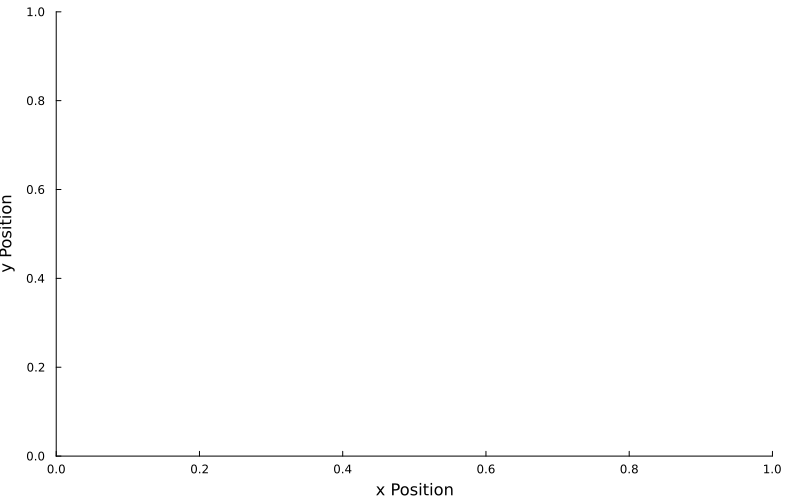

In [4]:
# Define the plot
num_points = 50

plt_grid_x1 = [domain[1][1] + i * (domain[1][2] - domain[1][1]) / num_points for j in 0:num_points, i in 0:num_points]
plt_grid_x2 = [domain[2][1] + j * (domain[2][2] - domain[2][1]) / num_points for j in 0:num_points, i in 0:num_points]

grid = range(0, stop=1, length=(num_points + 1))
plot_size = (400, 250) .* 2
plt = heatmap(xlims=domain[1], ylims=domain[2], xlabel="x Position", ylabel="y Position", color=:viridis, colorbar_title="Amplitude", size=plot_size, grid=false)

In [5]:
ops = gaussian_operators_2D(0.05, plt_grid_x1, plt_grid_x2)

Operators(var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}(0.05, [0.0 0.02 … 0.98 1.0; 0.0 0.02 … 0.98 1.0; … ; 0.0 0.02 … 0.98 1.0; 0.0 0.02 … 0.98 1.0], [0.0 0.0 … 0.0 0.0; 0.02 0.02 … 0.02 0.02; … ; 0.98 0.98 … 0.98 0.98; 1.0 1.0 … 1.0 1.0], var"#gauss2DN#37"{var"#gauss2D#36"}(var"#gauss2D#36"())), var"#Φ#40"{var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}}(var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}(0.05, [0.0 0.02 … 0.98 1.0; 0.0 0.02 … 0.98 1.0; … ; 0.0 0.02 … 0.98 1.0; 0.0 0.02 … 0.98 1.0], [0.0 0.0 … 0.0 0.0; 0.02 0.02 … 0.02 0.02; … ; 0.98 0.98 … 0.98 0.98; 1.0 1.0 … 1.0 1.0], var"#gauss2DN#37"{var"#gauss2D#36"}(var"#gauss2D#36"()))), var"#adjΦ#41"{Matrix{Float64}, Matrix{Float64}, var"#adjΦ#35#42"{var"#ϕ#38"{Float64, Matrix{Float64}, Matrix{Float64}, var"#gauss2DN#37"{var"#gauss2D#36"}}}}([0.0 0.02 … 0.98 1.0; 0.0 0.02 … 0.98 1.0; … ; 0.0 0.02 … 

## Pre-certificate

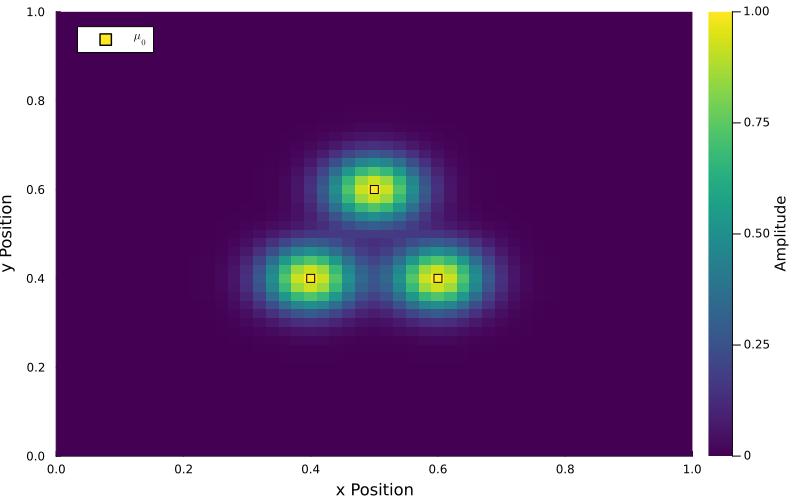

In [6]:
x0 = [[0.4, 0.5, 0.6], [0.4, 0.6, 0.4]]
a0 = [1.0, 1.0, 1.0]

μ0 = DiscreteMeasure(x0, a0)

ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, grid, grid, ηV, color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", marker=:square)

### SFW

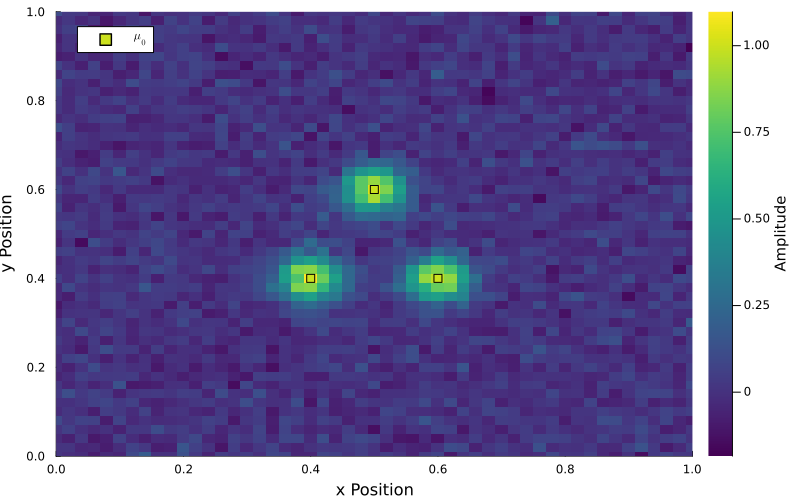

In [ ]:
y0 = ops.Φ(μ0...)

function add_noise(y0, noise_level)
    sigma = noise_level * norm(y0)
    w = randn(length(y0))
    w = w / norm(w) * sigma
    y = y0 + w
    return y
end

# Add noise to the observation y = y0 + w
noise_level = 0.5
y = add_noise(y0, noise_level)

plt_obs = deepcopy(plt)

heatmap!(plt_obs, grid, grid, reshape(y, size(plt_grid_x1)), color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", marker=:square)

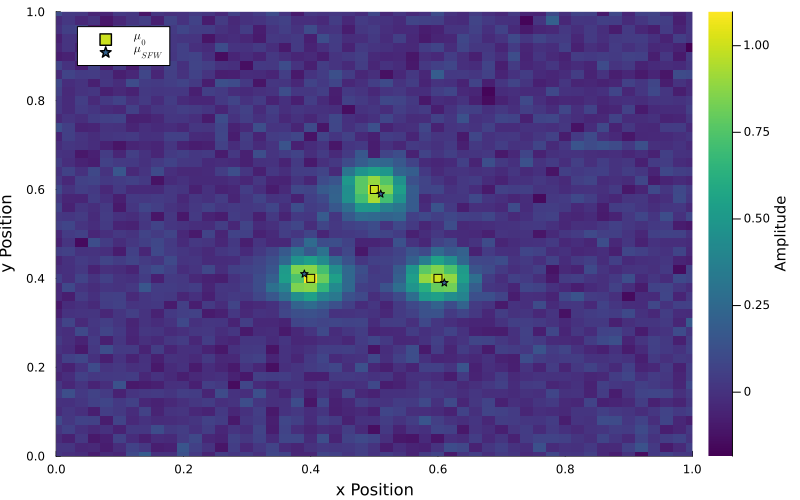

In [41]:
λ = 8

prob = BLASSO(y, ops, λ, domain)
solve!(prob, :SFW, options=Dict(:maxits => 100))

plt_sfw = deepcopy(plt)

heatmap!(plt_sfw, grid, grid, reshape(y, size(plt_grid_x1)), label="y_0", color=:viridis)
plot_spikes!(plt_sfw, μ0, label=L"μ_0", colorscheme=:viridis, marker=:square)
plot_spikes!(plt_sfw, prob.μ, label=L"μ_{SFW}", colorscheme=:viridis, marker=:star)

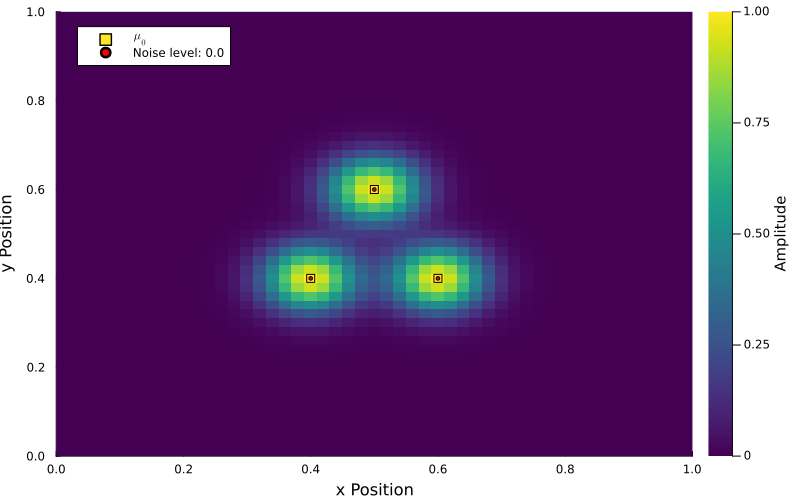

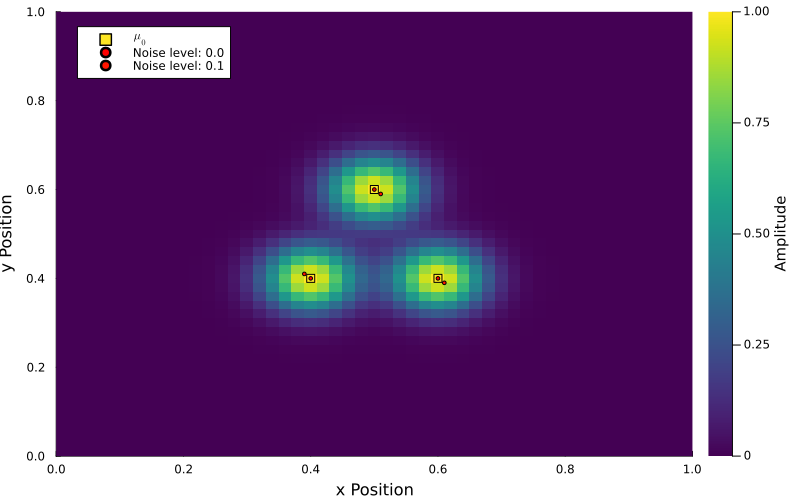

Solving... 100%|█| Time: 0:03:36


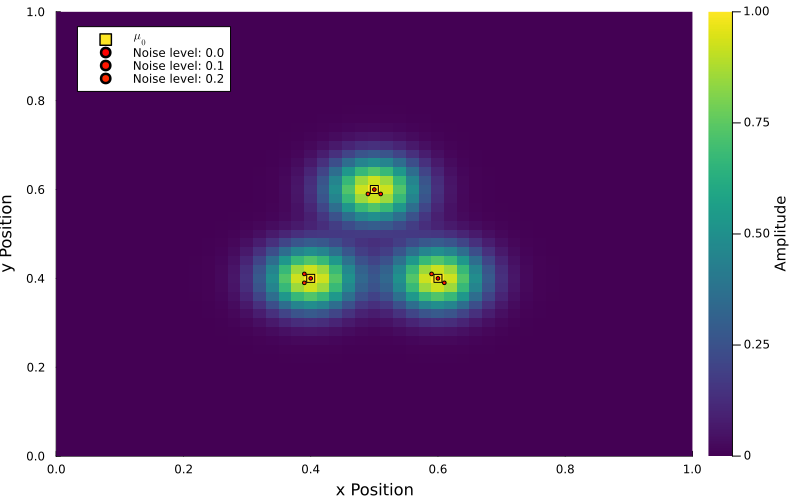

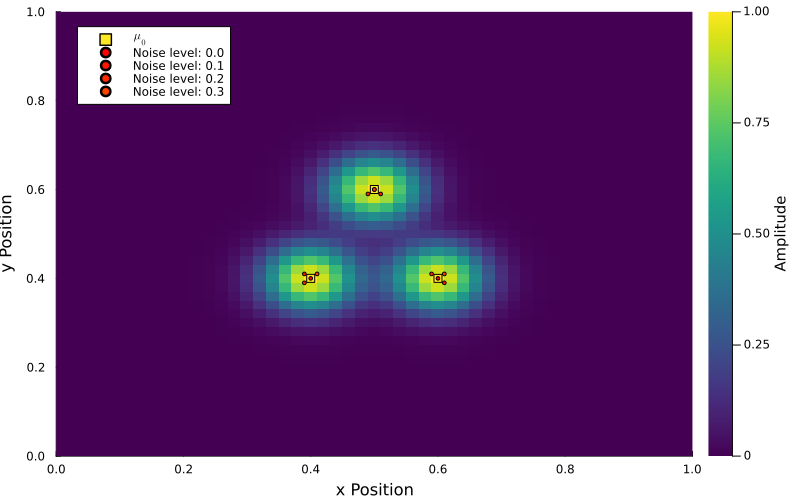

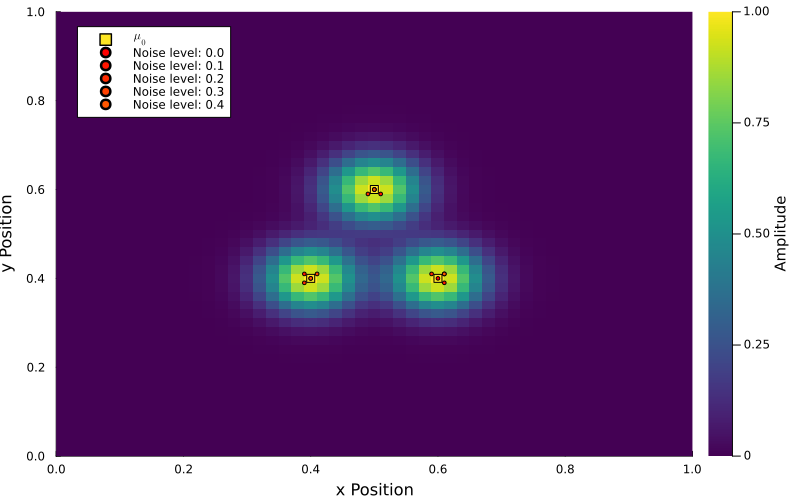

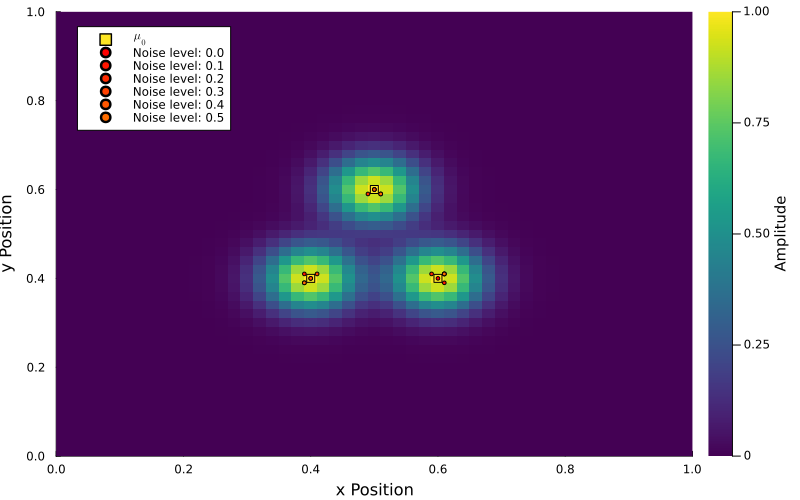

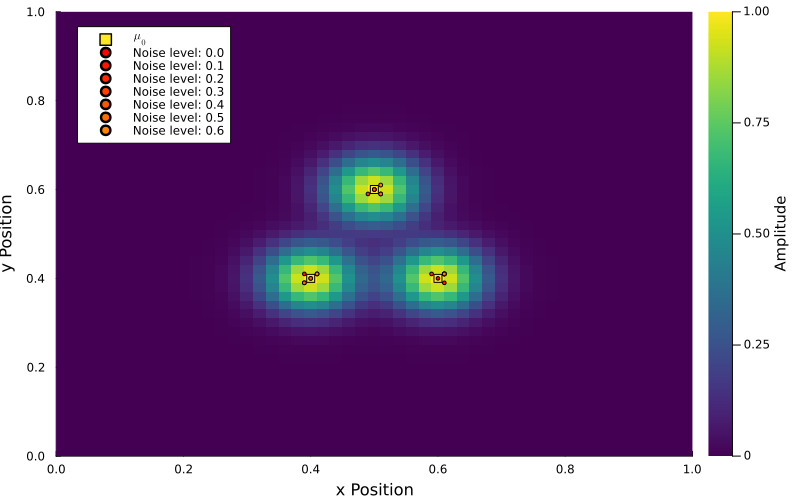

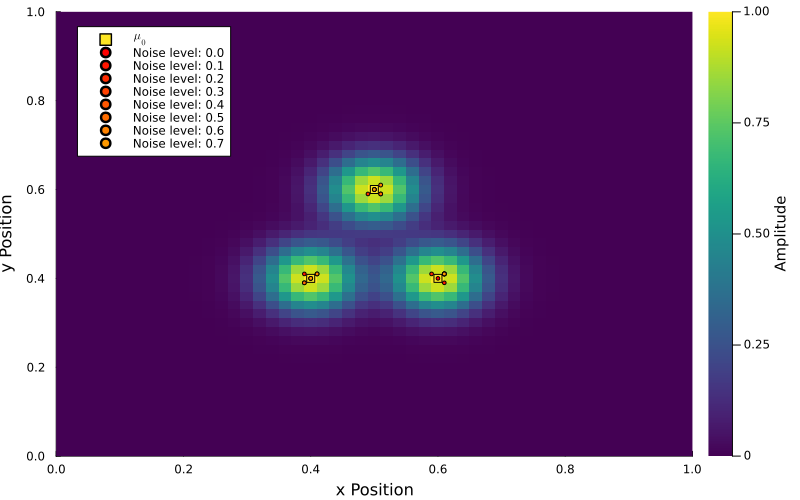

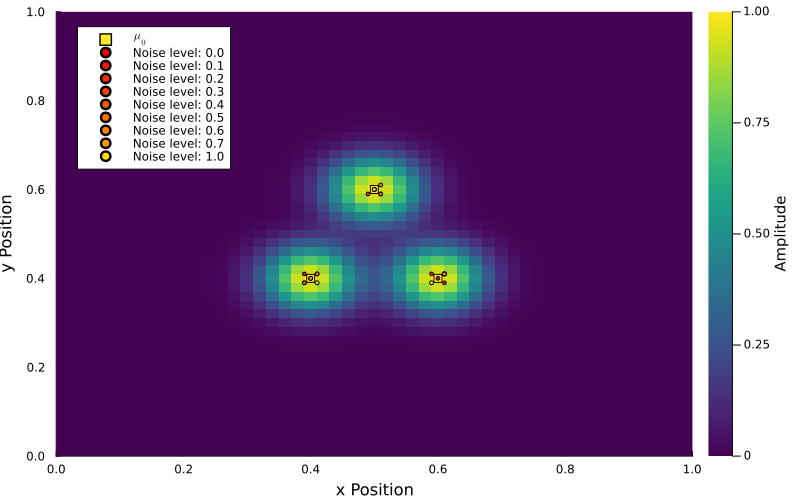

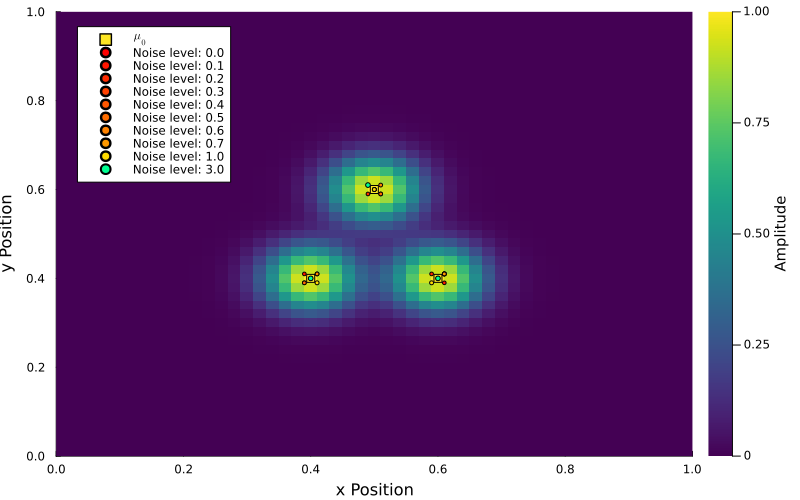

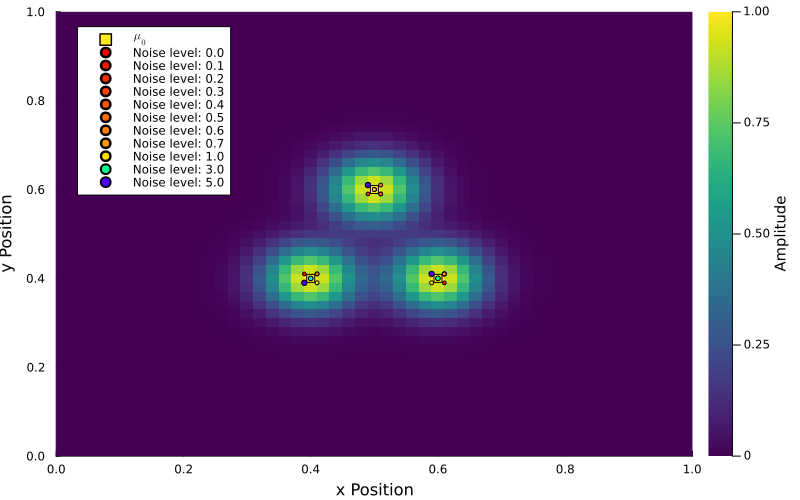

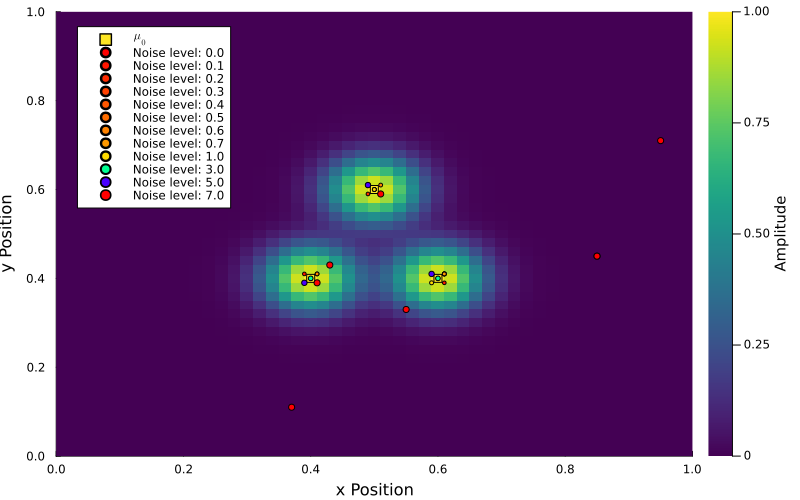

In [42]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 3, 5, 7]
λs = [0.001, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7]

plt_cert_behav = deepcopy(plt_cert)

Random.seed!(42) # use a fixed seed for reproducibility
using ProgressMeter

p = Progress(length(noise_levels), 1, "Solving...", 1)

for (i, noise_level) in enumerate(noise_levels)
    prob.y = add_noise(y0, noise_level)
    prob.λ = λs[i]
    solve!(prob, :SFW)
    marker_size = 2 + 0.2noise_level  # Scale marker size based on noise level
    scatter!(plt_cert_behav, prob.μ.x..., color=HSL(noise_level*360/7, 1, 0.5), marker=:circle, markersize=marker_size, label="Noise level: $(noise_level)")
    display(plt_cert_behav)
    next!(p)
end

# plt_cert_behav

1.9885306038868946

1.962319711500117

1.9544466985670652

1.0285676547263818

0.9999994905487555

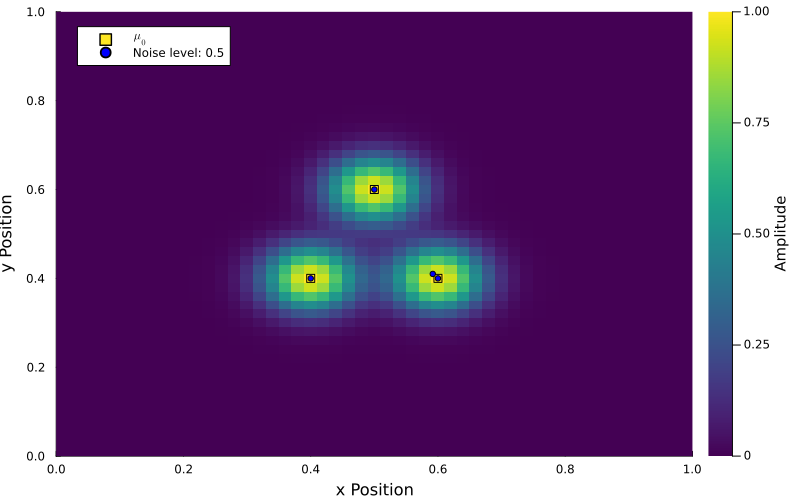

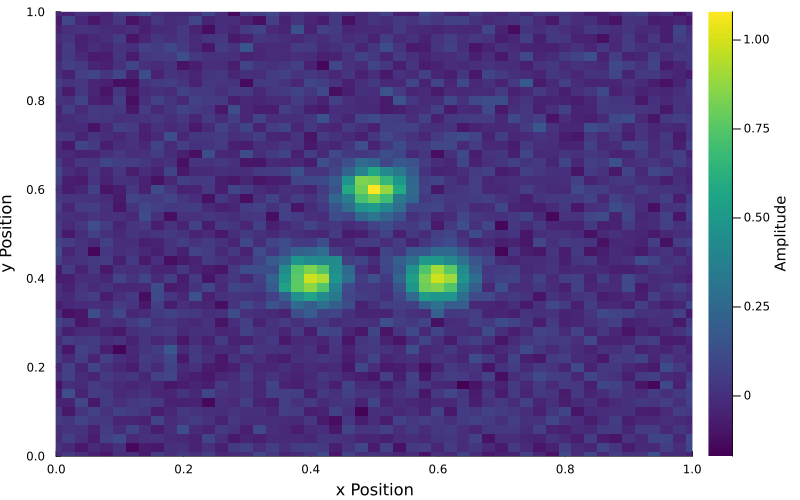

In [57]:
noise_levels = [0.5]
noise_colors = [:blue]
λs = [5]

plt_cert_behav = deepcopy(plt_cert)

Random.seed!(42) # use a fixed seed for reproducibility

for (i, noise_level) in enumerate(noise_levels)
    prob.y = add_noise(y0, noise_level)
    prob.λ = λs[i]
    solve!(prob, :SFW)
    marker_size = 2 + 2noise_level  # Scale marker size based on noise level
    scatter!(plt_cert_behav, prob.μ.x..., color=noise_colors[i], marker=:circle, markersize=marker_size, label="Noise level: $(noise_level)")
    display(plt_cert_behav)
end
plt_obs2 = deepcopy(plt)

heatmap!(plt_obs2, grid, grid, reshape(prob.y, size(plt_grid_x1)), color=:viridis)

1.9885306038868946

1.962319711500117

1.9544466985670652

1.0285676547263818

0.9999994905487555

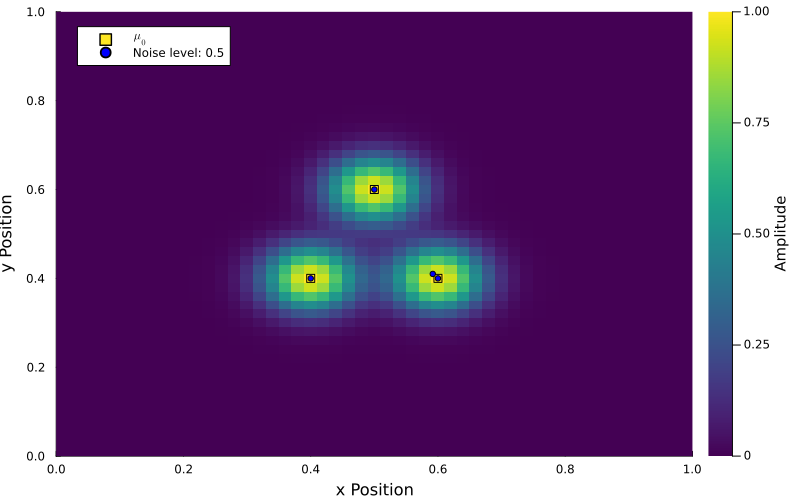

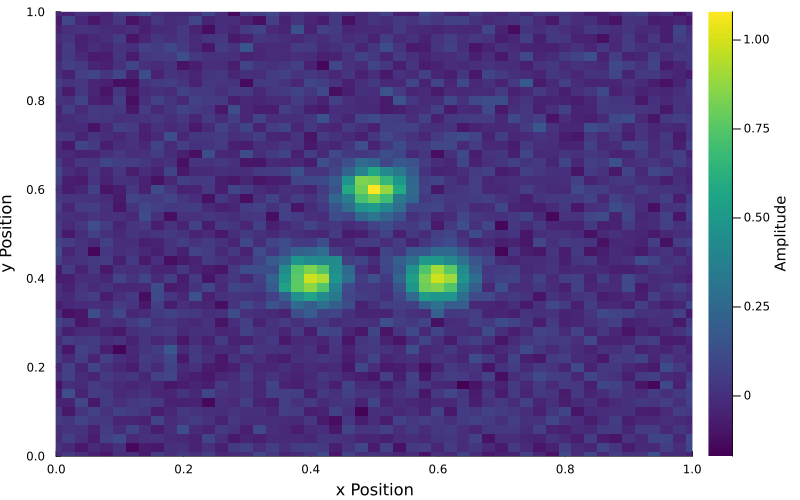

In [ ]:
noise_levels = [0.5]
noise_colors = [:blue]
λs = [5]

plt_cert_behav = deepcopy(plt_cert)

Random.seed!(42) # use a fixed seed for reproducibility

for (i, noise_level) in enumerate(noise_levels)
    prob.y = add_noise(y0, noise_level)
    prob.λ = λs[i]
    solve!(prob, :SFW)
    marker_size = 2 + 2noise_level  # Scale marker size based on noise level
    scatter!(plt_cert_behav, prob.μ.x..., color=noise_colors[i], marker=:circle, markersize=marker_size, label="Noise level: $(noise_level)")
    display(plt_cert_behav)
end
plt_obs2 = deepcopy(plt)

heatmap!(plt_obs2, grid, grid, reshape(prob.y, size(plt_grid_x1)), color=:viridis)

1.9885306038868946

1.962319711500117

1.9544466985670652

1.0285676547263818

0.9999994905487555

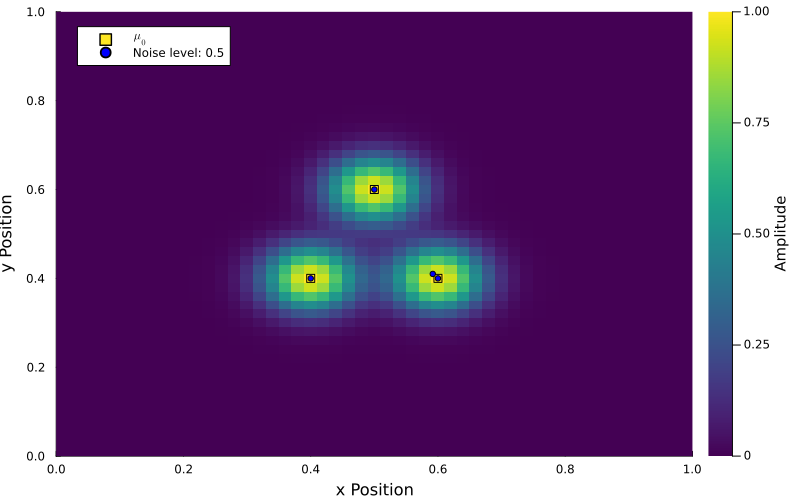

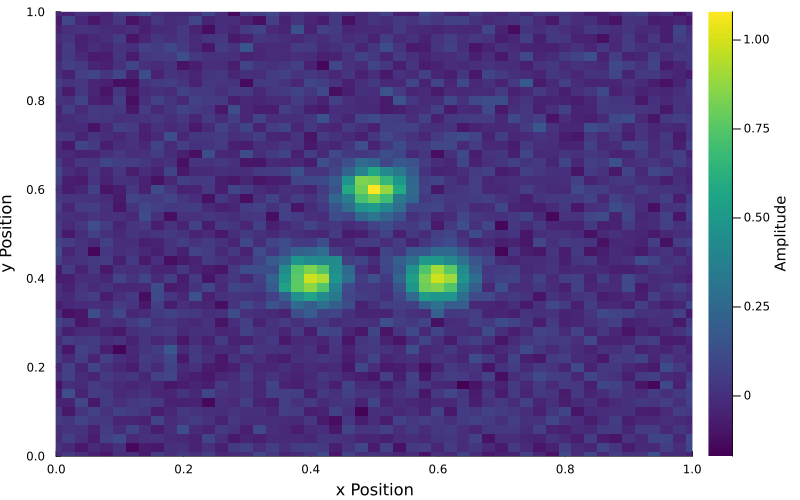

In [ ]:
noise_levels = [0.5]
noise_colors = [:blue]
λs = [5]

plt_cert_behav = deepcopy(plt_cert)

Random.seed!(42) # use a fixed seed for reproducibility

for (i, noise_level) in enumerate(noise_levels)
    prob.y = add_noise(y0, noise_level)
    prob.λ = λs[i]
    solve!(prob, :SFW)
    marker_size = 2 + 2noise_level  # Scale marker size based on noise level
    scatter!(plt_cert_behav, prob.μ.x..., color=noise_colors[i], marker=:circle, markersize=marker_size, label="Noise level: $(noise_level)")
    display(plt_cert_behav)
end
plt_obs2 = deepcopy(plt)

heatmap!(plt_obs2, grid, grid, reshape(prob.y, size(plt_grid_x1)), color=:viridis)